In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier


In [3]:
import pandas as pd

df = pd.read_csv("/Users/anhuynh/Downloads/heart_2020_cleaned.csv.zip")

df


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,Yes,27.41,Yes,No,No,7.0,0.0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6.0,Yes,No,No
319791,No,29.84,Yes,No,No,0.0,0.0,No,Male,35-39,Hispanic,No,Yes,Very good,5.0,Yes,No,No
319792,No,24.24,No,No,No,0.0,0.0,No,Female,45-49,Hispanic,No,Yes,Good,6.0,No,No,No
319793,No,32.81,No,No,No,0.0,0.0,No,Female,25-29,Hispanic,No,No,Good,12.0,No,No,No


In [3]:
heart_counts = df['HeartDisease'].value_counts().to_frame(name='Count')
heart_counts['Percentage'] = df['HeartDisease'].value_counts(normalize=True) * 100
print(heart_counts)


               Count  Percentage
HeartDisease                    
No            292422   91.440454
Yes            27373    8.559546


This dataset is very imbalanced and thus I need to apply strategies that help your model learn the minority class better and avoid being biased toward the majority class.



In [4]:
print(df.dtypes)


HeartDisease         object
BMI                 float64
Smoking              object
AlcoholDrinking      object
Stroke               object
PhysicalHealth      float64
MentalHealth        float64
DiffWalking          object
Sex                  object
AgeCategory          object
Race                 object
Diabetic             object
PhysicalActivity     object
GenHealth            object
SleepTime           float64
Asthma               object
KidneyDisease        object
SkinCancer           object
dtype: object


In [4]:

# Split features and target
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease'].map({'No': 0, 'Yes': 1})  # still 'object', will be encoded later

# Identify column types
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing for numerical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))  # drop binary to avoid multicollinearity
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])





In [5]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [9]:
xgbmodel_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])


# Fit pipeline
xgbmodel_pipeline.fit(X_train, y_train)

# Evaluate
accuracy = xgbmodel_pipeline.score(X_test, y_test)
print(f"Model accuracy on test set: {accuracy:.2%}")

evaluate_model(xgbmodel_pipeline, X_test, y_test)

Model accuracy on test set: 91.65%

Classification Report:
                 precision    recall  f1-score   support

No HeartDisease       0.92      0.99      0.96     87727
   HeartDisease       0.57      0.10      0.16      8212

       accuracy                           0.92     95939
      macro avg       0.75      0.54      0.56     95939
   weighted avg       0.89      0.92      0.89     95939



The XGBoost model is performing well overall, but it still struggles to accurately predict cases of Heart Disease due to class imbalance. In this scenario, my priority is to maximize the recall score for the Heart Disease class, as it is crucial to identify all clients who may be at potential risk. 

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:01:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:01:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔍 Evaluation for: XGBoost + scale_pos_weight


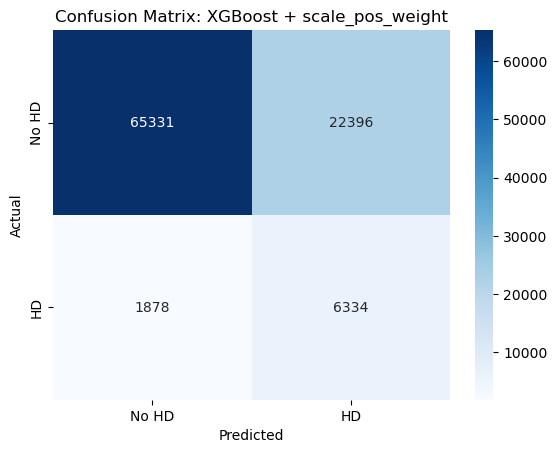

                 precision    recall  f1-score   support

No HeartDisease       0.97      0.74      0.84     87727
   HeartDisease       0.22      0.77      0.34      8212

       accuracy                           0.75     95939
      macro avg       0.60      0.76      0.59     95939
   weighted avg       0.91      0.75      0.80     95939


🔍 Evaluation for: XGBoost + SMOTE


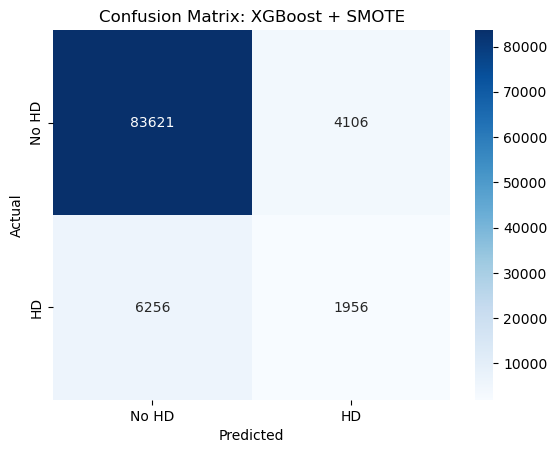

                 precision    recall  f1-score   support

No HeartDisease       0.93      0.95      0.94     87727
   HeartDisease       0.32      0.24      0.27      8212

       accuracy                           0.89     95939
      macro avg       0.63      0.60      0.61     95939
   weighted avg       0.88      0.89      0.88     95939



In [10]:
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prep your data
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease'].map({'No': 0, 'Yes': 1})

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Column selection
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

# Preprocessors
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# -----------------------------
# MODEL 1: XGBoost with scale_pos_weight
# -----------------------------
imbalance_ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
xgb_weighted_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                                 scale_pos_weight=imbalance_ratio,
                                 max_delta_step=1,
                                 random_state=23))
])

xgb_weighted_pipeline.fit(X_train, y_train)
y_pred_weighted = xgb_weighted_pipeline.predict(X_test)

# -----------------------------
# MODEL 2: XGBoost with SMOTE
# -----------------------------
smote = SMOTE(random_state=42)
xgb_smote_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=23))
])

xgb_smote_pipeline.fit(X_train, y_train)
y_pred_smote = xgb_smote_pipeline.predict(X_test)

# -----------------------------
# EVALUATION FUNCTION
# -----------------------------
def evaluate_model(name, y_test, y_pred):
    print(f"\n🔍 Evaluation for: {name}")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No HD', 'HD'], yticklabels=['No HD', 'HD'])
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    print(classification_report(y_test, y_pred, target_names=['No HeartDisease', 'HeartDisease']))

# -----------------------------
# COMPARE RESULTS
# -----------------------------
evaluate_model("XGBoost + scale_pos_weight", y_test, y_pred_weighted)
evaluate_model("XGBoost + SMOTE", y_test, y_pred_smote)


With the imbalanced class, I tried two methods to help the model by using Smote and XGBoost with scale_pos_weight. With the better recall score of 77% Heart Disease, the XGBoost with scale_pos_weight is doing the best. 



In [11]:
# AdaBoost with class_weight via estimator param
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

weighted_estimator = DecisionTreeClassifier(max_depth=1, class_weight={0: 1, 1: imbalance_ratio})

ada_weighted_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(estimator=weighted_estimator, random_state=23))
])

ada_weighted_pipeline.fit(X_train, y_train)
y_pred_ada_weighted = ada_weighted_pipeline.predict(X_test)



/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [12]:
# -----------------------------
# MODEL 4: AdaBoost with SMOTE
# -----------------------------

ada_smote_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        random_state=23
    ))
])

ada_smote_pipeline.fit(X_train, y_train)
y_pred_ada_smote = ada_smote_pipeline.predict(X_test)



/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



🔍 Evaluation for: AdaBoost + class_weight


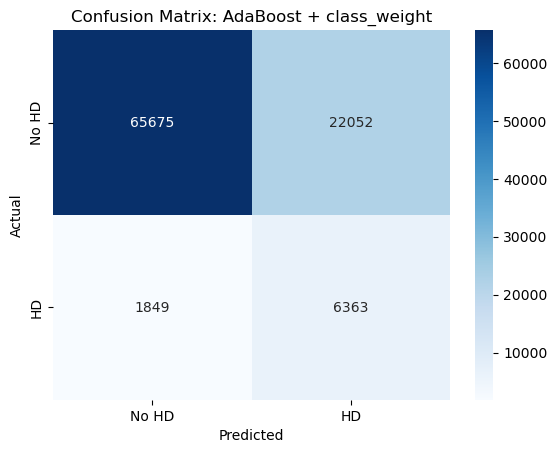

                 precision    recall  f1-score   support

No HeartDisease       0.97      0.75      0.85     87727
   HeartDisease       0.22      0.77      0.35      8212

       accuracy                           0.75     95939
      macro avg       0.60      0.76      0.60     95939
   weighted avg       0.91      0.75      0.80     95939


🔍 Evaluation for: AdaBoost + SMOTE


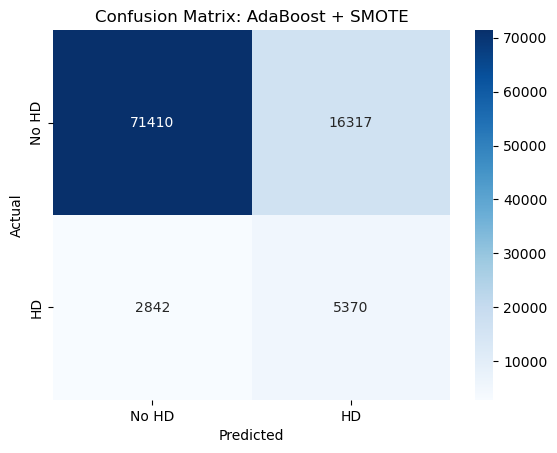

                 precision    recall  f1-score   support

No HeartDisease       0.96      0.81      0.88     87727
   HeartDisease       0.25      0.65      0.36      8212

       accuracy                           0.80     95939
      macro avg       0.60      0.73      0.62     95939
   weighted avg       0.90      0.80      0.84     95939



In [13]:
evaluate_model("AdaBoost + class_weight", y_test, y_pred_ada_weighted)
evaluate_model("AdaBoost + SMOTE", y_test, y_pred_ada_smote)


With the imbalanced class, I tried two methods to help the model by using Smote and AdaBoost with scale_pos_weight. With the better recall score of 77% Heart Disease, the AdaBoost with scale_pos_weight is doing the best. 


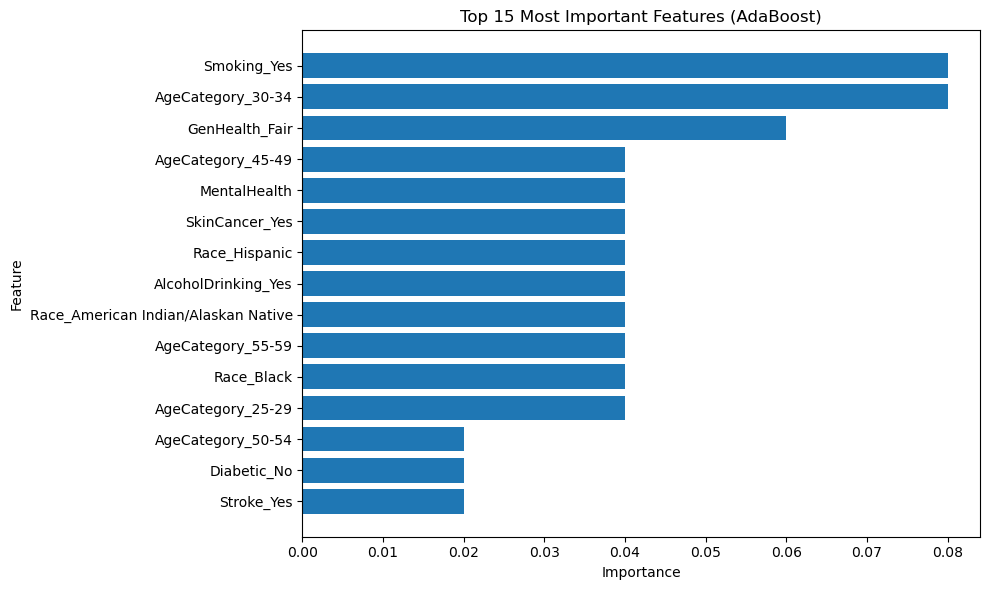

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define your feature groups
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Get feature importances from the trained AdaBoost pipeline
ada_feature_importances = ada_weighted_pipeline.named_steps['classifier'].feature_importances_

# Extract feature names from the preprocessor
categorical_feature_names = ada_weighted_pipeline.named_steps['preprocessor'] \
    .named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine all feature names in order used by model
all_feature_names = np.concatenate([categorical_feature_names, numerical_features])

# Create DataFrame for importances
ada_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': ada_feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot top N features
top_n = 15
plt.figure(figsize=(10, 6))
plt.barh(
    ada_importance_df['Feature'].head(top_n)[::-1],
    ada_importance_df['Importance'].head(top_n)[::-1]
)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 15 Most Important Features (AdaBoost)')
plt.tight_layout()
plt.show()


Our analysis shows that the most influential factors associated with heart disease risk are smoking habits, age, general health, and mental well-being. Both the AdaBoost and XGBoost models performed similarly in terms of recall and precision, suggesting they are equally effective at identifying individuals who may be at risk. In this context, I prioritized recall because it's more important to flag potential cases than to risk missing someone who truly needs care. These models could serve as helpful tools for healthcare providers, allowing them to prioritize patients for follow-up testing and preventative care using straightforward, accessible health data.